In [1]:
from collections import defaultdict
from math import pi, cos, sin
import matplotlib.pyplot as plt
from skimage import io, feature, transform

In [2]:
full_moon = io.imread("../imgs/WAC_GL000.tif")

Text(0.5, 1.0, 'Vybrany vyrez z mesiaca')

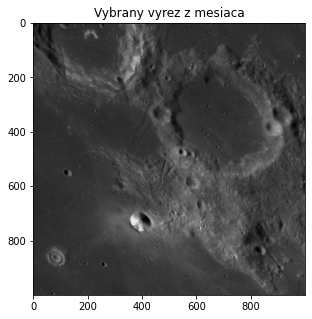

In [3]:
Xline_moon = 25500
Yline_moon = 10000
step_moon = 1000

part_moon  = full_moon[Xline_moon:Xline_moon + step_moon, 
             Yline_moon:Yline_moon + step_moon]

# Vyplotovanie vybranej časti mesiaca
plt.figure(figsize=(5, 5))
plt.imshow(part_moon,  cmap='gray')
plt.title('Vybrany vyrez z mesiaca')

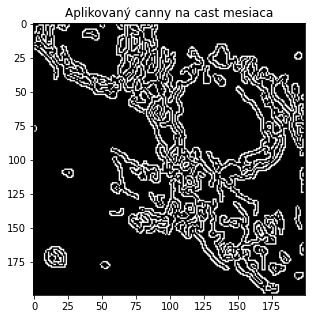

In [4]:
# Resize (na 200x200) part_moon obrazka a aplikovanie predspracovanie podla cannyho
resize_index = 5
resize_pm = transform.resize(part_moon, (int(step_moon/resize_index), int(step_moon/resize_index)))
canny_resize_pm = feature.canny(feature.canny(resize_pm)) # osvedcene 2x canny

# Vyplotovanie hran vyrezu (canny) vybranej casti mesiaca s rezize
plt.figure(figsize= (5, 5))
plt.title('Aplikovaný canny na cast mesiaca')
plt.imshow(canny_resize_pm, cmap='gray')

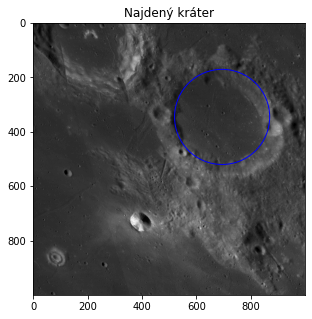

In [5]:
steps = 100 # krok pre hladanie kruznice
threshold = 0.4 # presnost pre ziskanie kruznice - viac ako 40% pix kruhov
r = 35 # priblizny hladany polomer 'velkeho' kratera

# Parametricke rovnice pre jednotlive body kruznice - x=a+r⋅cos(t) r=b+r⋅sin(t) t∈[0,2π)
# dot pre vsetky mozne kruhy s polomerom r
# a = int(r*cos(t)) 
# b = int(r*sin(t))
dot = []
for t in range(steps):
    dot.append((r, int(r*cos(2*pi*t/steps)), int(r*sin(2*pi*t/steps))))

# Pre kazdy kruh dot overime prekrytie kruhu v canny_resize_pm s polomerom r + vypocet bodov stredu
ac = defaultdict(int)
for x in range(canny_resize_pm.shape[0]):
    for y in range(canny_resize_pm.shape[1]):
        if canny_resize_pm[x][y]:
            for r, dx, dy in dot:
                a = x - dx
                b = y - dy
                ac[(a, b, r)] += 1

# Prepisanie do kruznic a ziskanie stredu kruznice - x y
circles = []
for k, v in sorted(ac.items(), key=lambda i: -i[1]):
    x, y, r = k
    if v / steps >= threshold and all((x - xc)**2 + (y - yc)**2 > rc**2 for xc, yc, rc in circles):
        circles.append((x, y, r))

# Vyplotovanie najdeneho krateru a zobrazenie kruhu s polomerom r na part_moon
count_circle = 0 # definovanie poctu 'velkych' kruhov
fig, ax = plt.subplots(figsize= (5, 5))
ax.imshow(part_moon, cmap='gray')
plt.title('Najdený kráter')
# spatny resize na part_moon velkost
for circle in circles:
    ax.add_artist(plt.Circle((circle[1]*resize_index, circle[0]*resize_index), circle[2]*resize_index, color= 'b', fill=False))
    Ycircle_partMoon = circle[1]*resize_index
    Xcircle_partMoon = circle[0]*resize_index
    Rcircle_partMoon = circle[2]*resize_index
    count_circle += 1
    if count_circle == 1:
        plt.show()
        break


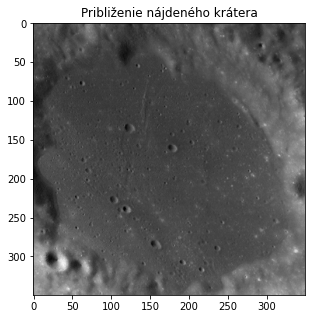

In [6]:
startX = (Rcircle_partMoon - Xcircle_partMoon) * -1
startY = (Rcircle_partMoon - Ycircle_partMoon) * -1
          
zoom_crater = part_moon[startX:Rcircle_partMoon + Xcircle_partMoon, startY:Rcircle_partMoon + Ycircle_partMoon]
plt.figure(figsize=(5, 5))
plt.title('Približenie nájdeného krátera')
plt.imshow(zoom_crater, cmap='gray')

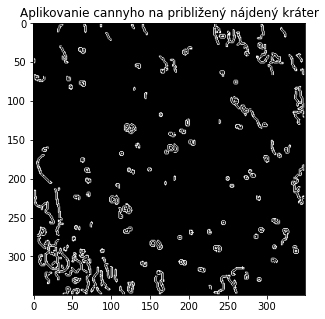

In [7]:
canny_zoom_crater = feature.canny(feature.canny(zoom_crater), sigma= 0.1)
plt.figure(figsize=(5, 5))
plt.title('Aplikovanie cannyho na približený nájdený kráter')
plt.imshow(canny_zoom_crater, cmap='gray')

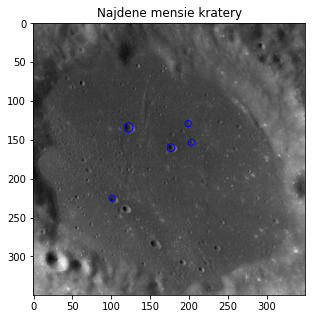

In [8]:
Rmin = 4 # priblizny max hladany polomer 'malého' kratera
Rmax = 12 # priblizny min hladany polomer 'malého' kratera
steps = 100 # krok pre hladanie kruznice
threshold = 0.53 # presnost pre ziskanie kruznice - viac ako 53% pix kruhov

# Parametricke rovnice pre jednotlive body kruznice - x=a+r⋅cos(t) r=b+r⋅sin(t) t∈[0,2π)
# dot pre vsetky mozne kruhy s polomerom r
# a = int(r*cos(t)) 
# b = int(r*sin(t))
dot = []
for r in range(Rmin, Rmax + 1):
    for t in range(steps):
        dot.append((r, int(r * cos(2 * pi * t / steps)), int(r * sin(2 * pi * t / steps))))

# Pre kazdy kruh dot overime prekrytie kruhu v canny_resize_pm s polomerom r + vypocet bodov stredu
ac = defaultdict(int)
for x in range(canny_zoom_crater.shape[0]):
    for y in range(canny_zoom_crater.shape[1]):
        if canny_zoom_crater[x][y]:
            for r, dx, dy in dot:
                a = x - dx
                b = y - dy
                ac[(a, b, r)] += 1

# Prepisanie do kruznic a ziskanie stredu kruznice - x y
circles = []
for k, v in sorted(ac.items(), key=lambda i: -i[1]):
    x, y, r = k
    if v / steps >= threshold and all((x - xc) ** 2 + (y - yc) ** 2 > rc ** 2 for xc, yc, rc in circles):
        circles.append((x, y, r))
        
# Vyplotovanie najdeneho krateru a zobrazenie kruhu s polomerom r na zoom_crater
fig, ax = plt.subplots(figsize= (5, 5))
ax.imshow(zoom_crater, cmap='gray')
plt.title("Najdene mensie kratery")
count_circle = 0
five_craters = []
frame = int(canny_zoom_crater.shape[0]/4)
for circle in circles:
    if frame < circle[0] < canny_zoom_crater.shape[0] - frame \
            and frame < circle[1] < canny_zoom_crater.shape[0] - frame:
        ax.add_artist(plt.Circle((circle[1],circle[0]), circle[2], color= 'b', fill= False)) # vykreslenie kruhov
        five_craters.append((circle[0], circle[1], circle[2])) #pridanie x, y, r do pola
        count_circle += 1
    if count_circle == 5:
        plt.show()
        break

In [9]:
for i in range(5):
    print(i+1,". maly krater : ")
    print("        X:", Xline_moon+(Xcircle_partMoon-Rcircle_partMoon)+five_craters[i][0])
    print("        Y:", Yline_moon+(Ycircle_partMoon-Rcircle_partMoon)+five_craters[i][1]) 
    print("        s polomerom cca: ", five_craters[i][2] )

print(" Velky krater :")
print(" X pozicia stredu velkeho kratera:", Xline_moon+Xcircle_partMoon)
print(" Y pozicia stredu velkeho kratera:", Yline_moon+Ycircle_partMoon)
print(" Priblizny polomer velkeho kratera: ", Rcircle_partMoon)

1 . maly krater : 
        X: 25830
        Y: 10697
        s polomerom cca:  5
2 . maly krater : 
        X: 25823
        Y: 10723
        s polomerom cca:  4
3 . maly krater : 
        X: 25804
        Y: 10642
        s polomerom cca:  6
4 . maly krater : 
        X: 25895
        Y: 10621
        s polomerom cca:  4
5 . maly krater : 
        X: 25799
        Y: 10719
        s polomerom cca:  4
 Velky krater :
 X pozicia stredu velkeho kratera: 25845
 Y pozicia stredu velkeho kratera: 10695
 Priblizny polomer velkeho kratera:  175
